In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dữ liệu từ các file txt, giả sử là dữ liệu được phân tách bằng tab
AAPL = pd.read_csv("/content/drive/MyDrive/AAPL.csv")
ABB = pd.read_csv("/content/drive/MyDrive/ABB.csv")
ABBV = pd.read_csv("/content/drive/MyDrive/ABBV.csv")
AMGN = pd.read_csv("/content/drive/MyDrive/AMGN.csv")
AEP = pd.read_csv("/content/drive/MyDrive/AEP.csv")

# Kiểm tra cấu trúc dataframe
print(AAPL.info())
print(ABB.info())
print(ABBV.info())
print(AMGN.info())
print(AEP.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  


In [ ]:
print(AAPL.head())
print(ABB.head())
print(ABBV.head())
print(AMGN.head())
print(AEP.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2012-09-04  95.108574  96.448570  94.928574  96.424286  87.121140   
1  2012-09-05  96.510002  96.621429  95.657143  95.747147  86.509338   
2  2012-09-06  96.167145  96.898575  95.828575  96.610001  87.288956   
3  2012-09-07  96.864288  97.497147  96.538574  97.205711  87.827171   
4  2012-09-10  97.207146  97.612854  94.585716  94.677139  85.542564   

      Volume  
0   91973000  
1   84093800  
2   97799100  
3   82416600  
4  121999500  
         Date       Open       High        Low      Close  Adj Close   Volume
0  2012-09-04  17.340000  17.370001  17.139999  17.240000  14.469431  1474300
1  2012-09-05  17.219999  17.389999  17.160000  17.320000  14.536574  3186600
2  2012-09-06  17.690001  17.959999  17.680000  17.910000  15.031758  3082300
3  2012-09-07  18.580000  18.700001  18.510000  18.650000  15.652837  3005200
4  2012-09-10  18.760000  18.770000  18.510000  18.540001  15.560513  1920300
         

In [ ]:
def find_and_replace_null_with_mean(df, name):
    null_rows = df[df.isnull().any(axis=1)]
    if not null_rows.empty:
        print(f"Các dòng chứa giá trị null trong {name}:")
        print(null_rows)

        for column in df.columns:
            if df[column].isnull().any():
                column_mean = df[column].mean()
                df[column].fillna(column_mean, inplace=True)
                print(f"Đã thay thế giá trị null trong cột {column} bằng giá trị mean của cột ({column_mean})")

    else:
        print(f"Không có giá trị null trong {name}.")

    return df

AAPL = find_and_replace_null_with_mean(AAPL, "AAPL")
ABB = find_and_replace_null_with_mean(ABB, "ABB")
ABBV = find_and_replace_null_with_mean(ABBV, "ABBV")
AMGN = find_and_replace_null_with_mean(AMGN, "AMGN")
AEP = find_and_replace_null_with_mean(AEP, "AEP")

Không có giá trị null trong AAPL.
Không có giá trị null trong ABB.
Không có giá trị null trong ABBV.
Không có giá trị null trong AMGN.
Không có giá trị null trong AEP.


In [ ]:
AAPL_not_Date = AAPL.drop(columns=['Date'])
ABB_not_Date = ABB.drop(columns=['Date'])
ABBV_not_Date = ABBV.drop(columns=['Date'])
AMGN_not_Date = AMGN.drop(columns=['Date'])
AEP_not_Date = AEP.drop(columns=['Date'])

In [ ]:
def detect_outliers_iqr(df):
    outliers_dict = {}

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers

    return outliers_dict

outliers = detect_outliers_iqr(AAPL_not_Date)
print("Outliers using IQR for each column:")
print(outliers)


Outliers using IQR for each column:
{'Open': Series([], Name: Open, dtype: float64), 'High': Series([], Name: High, dtype: float64), 'Low': Series([], Name: Low, dtype: float64), 'Close': Series([], Name: Close, dtype: float64), 'Adj Close': Series([], Name: Adj Close, dtype: float64), 'Volume': 6      178058300
8      150118500
14     159941600
20     156998100
24     159498500
         ...    
352    169625400
410    189977900
412    167371400
505    189846300
746    162206300
Name: Volume, Length: 64, dtype: int64}


In [ ]:
print("AAPL:")
print(AAPL.describe())

print("\nABB:")
print(ABB.describe())

print("\nABBV:")
print(ABBV.describe())

print("\nAMGN:")
print(AMGN.describe())

print("\nAEP:")
print(AEP.describe())


AAPL:
              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    101.852447   102.712367   100.941686   101.838638    97.588172   
std      25.736409    25.848582    25.623353    25.767121    26.981921   
min      55.424286    57.085712    55.014286    55.790001    50.932652   
25%      77.946430    78.596071    76.968212    77.706429    72.252803   
50%     101.415001   102.314999   100.560001   101.465000    97.495941   
75%     117.925001   119.152498   116.857500   118.180002   114.862888   
max     164.800003   164.940002   163.630005   164.050003   164.050003   

             Volume  
count  1.258000e+03  
mean   6.389123e+07  
std    4.399385e+07  
min    1.147590e+07  
25%    3.318375e+07  
50%    5.100075e+07  
75%    7.987358e+07  
max    3.652131e+08  

ABB:
              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  125

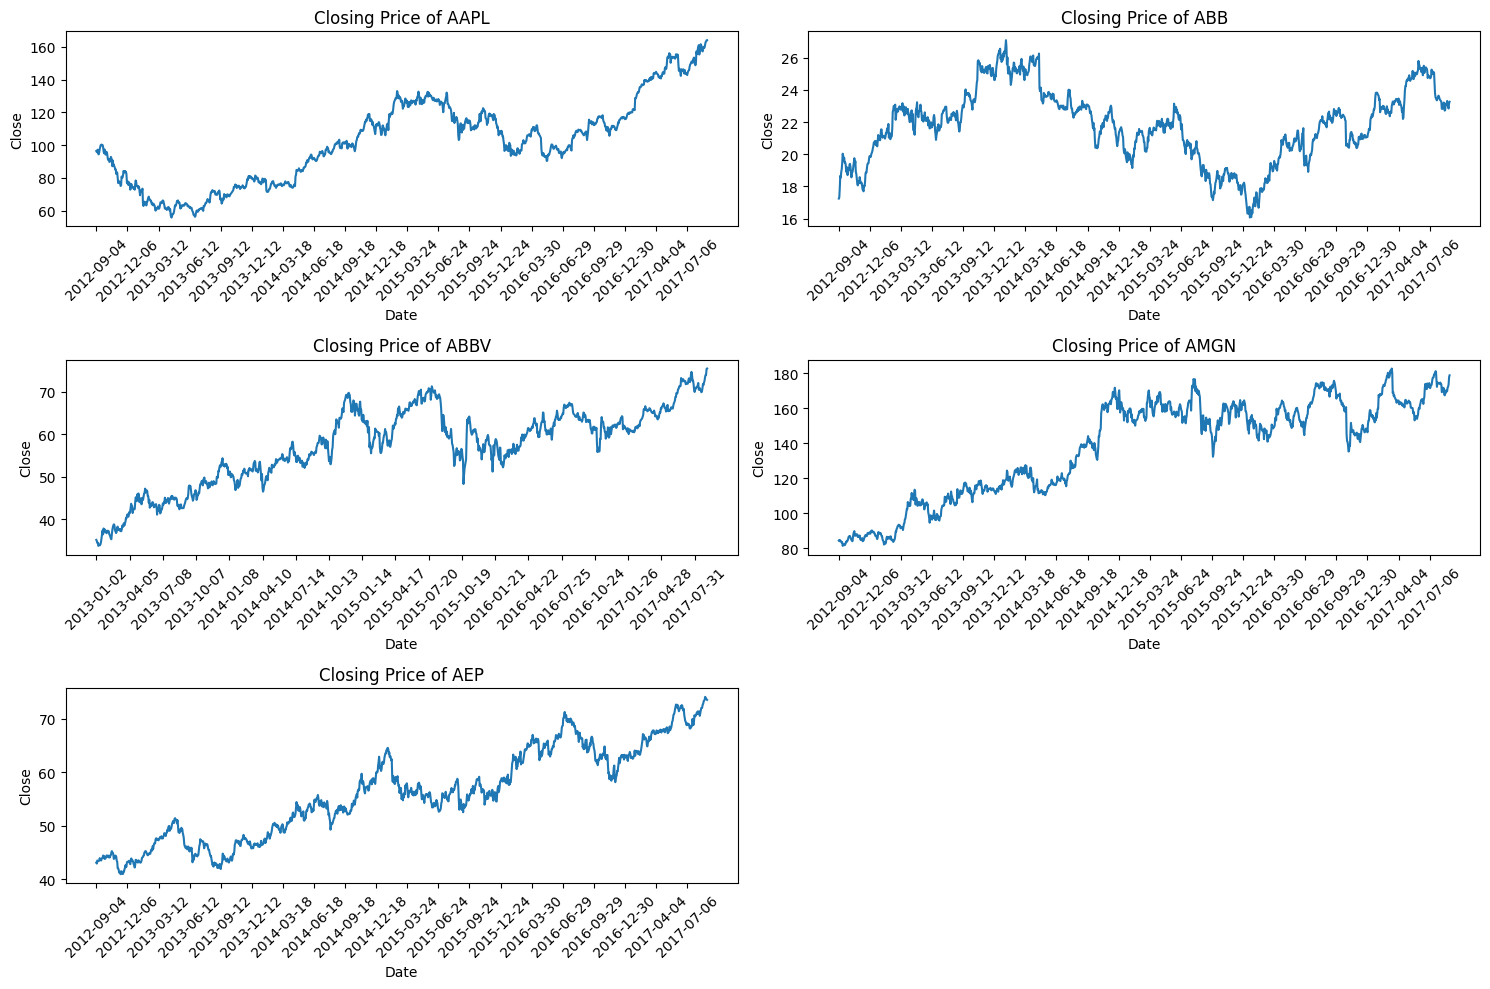

In [ ]:
import matplotlib.pyplot as plt

company_list = [AAPL, ABB, ABBV, AMGN, AEP]
company_list_not_date=[AAPL_not_Date, ABB_not_Date, ABBV_not_Date, AMGN_not_Date, AEP_not_Date]
tech_list = ['AAPL', 'ABB', 'ABBV', 'AMGN', 'AEP']


plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    plt.plot(company['Date'], company['Close'])
    plt.ylabel('Close')
    plt.xlabel('Date')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    xticks = range(0, len(company['Date']),64)  # Tạo list các vị trí cần hiển thị trên trục x
    plt.xticks(xticks, company['Date'].iloc[xticks], rotation=45)  # Đặt nhãn và xoay nhãn trục x

plt.tight_layout()
plt.show()


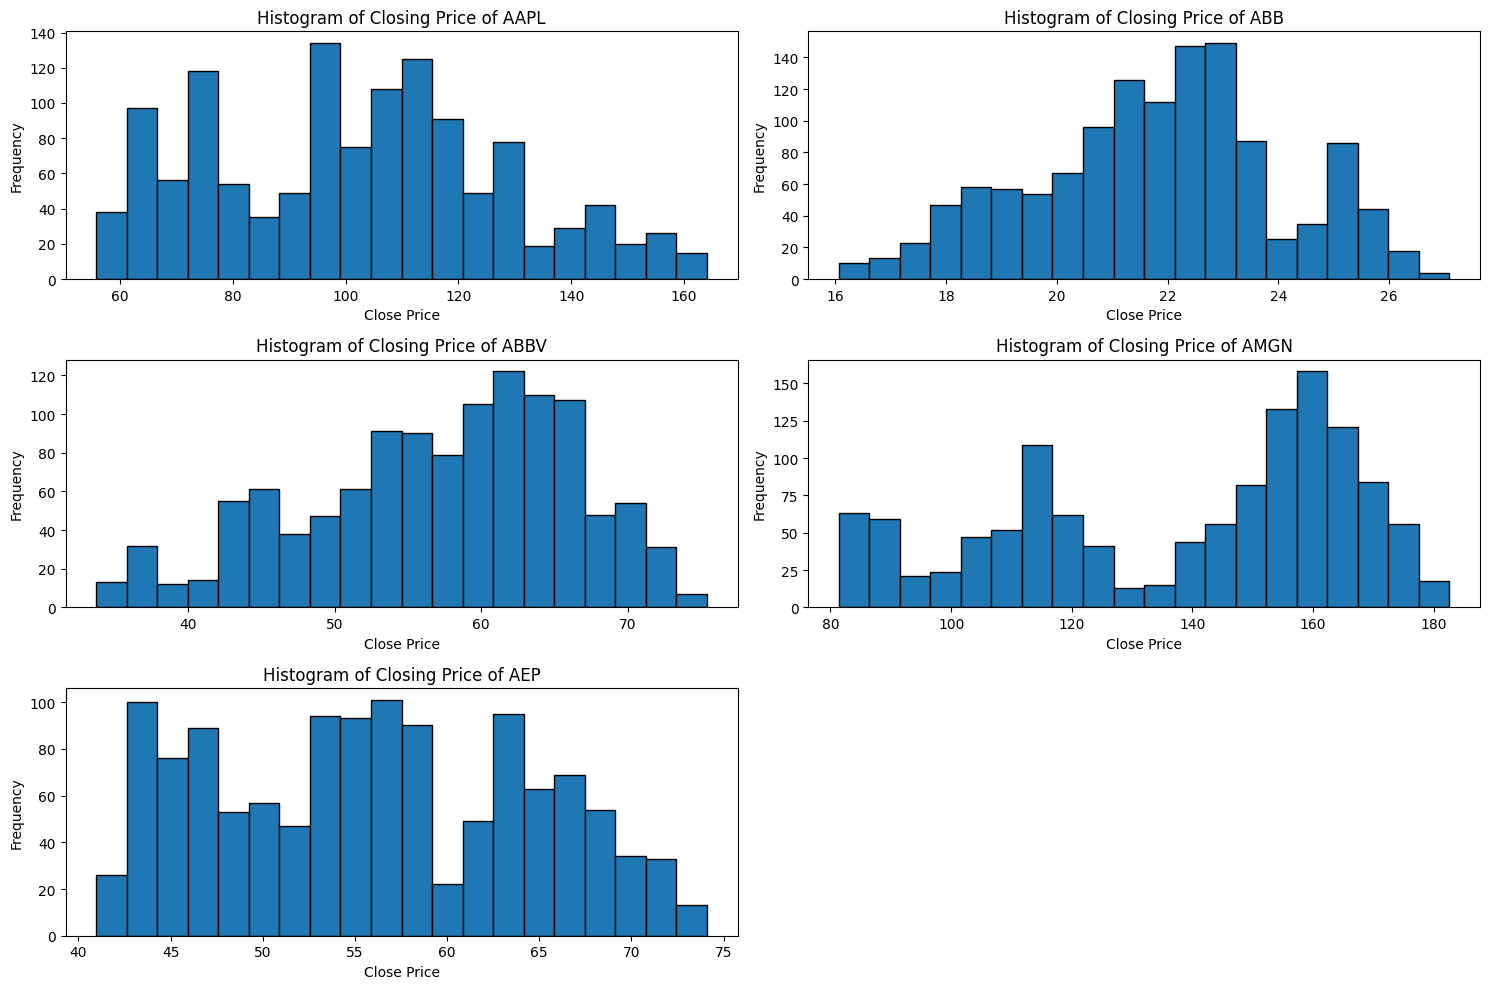

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    plt.hist(company['Close'], bins=20, edgecolor='black')
    plt.ylabel('Frequency')
    plt.xlabel('Close Price')
    plt.title(f"Histogram of Closing Price of {tech_list[i - 1]}")

plt.tight_layout()
plt.show()

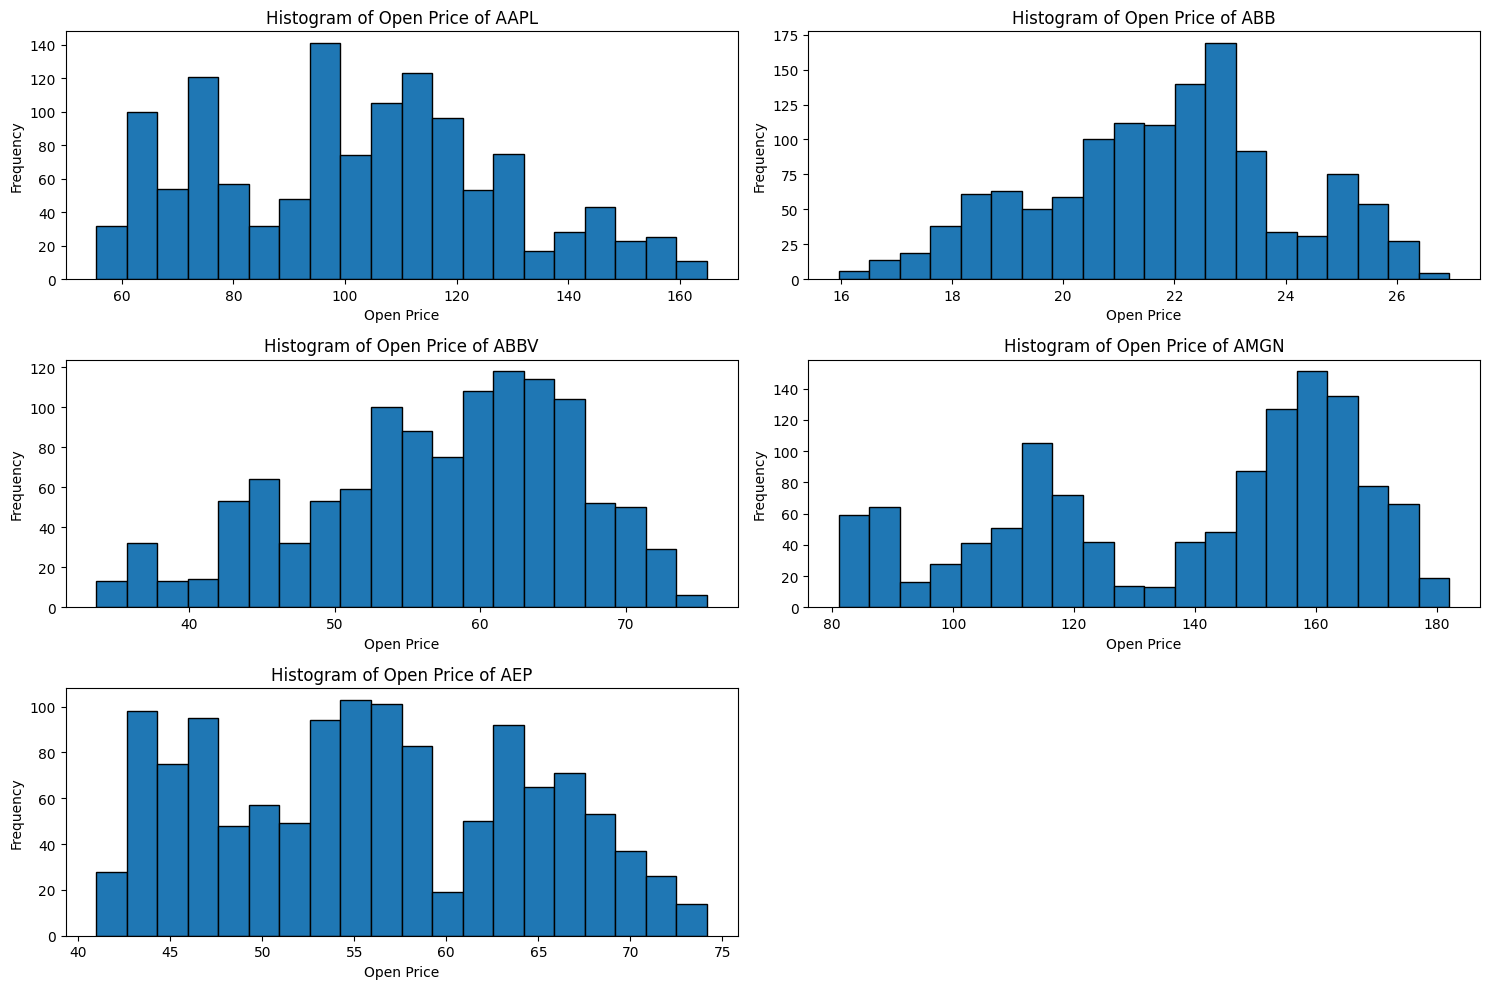

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    plt.hist(company['Open'], bins=20, edgecolor='black')
    plt.ylabel('Frequency')
    plt.xlabel('Open Price')
    plt.title(f"Histogram of Open Price of {tech_list[i - 1]}")

plt.tight_layout()
plt.show()

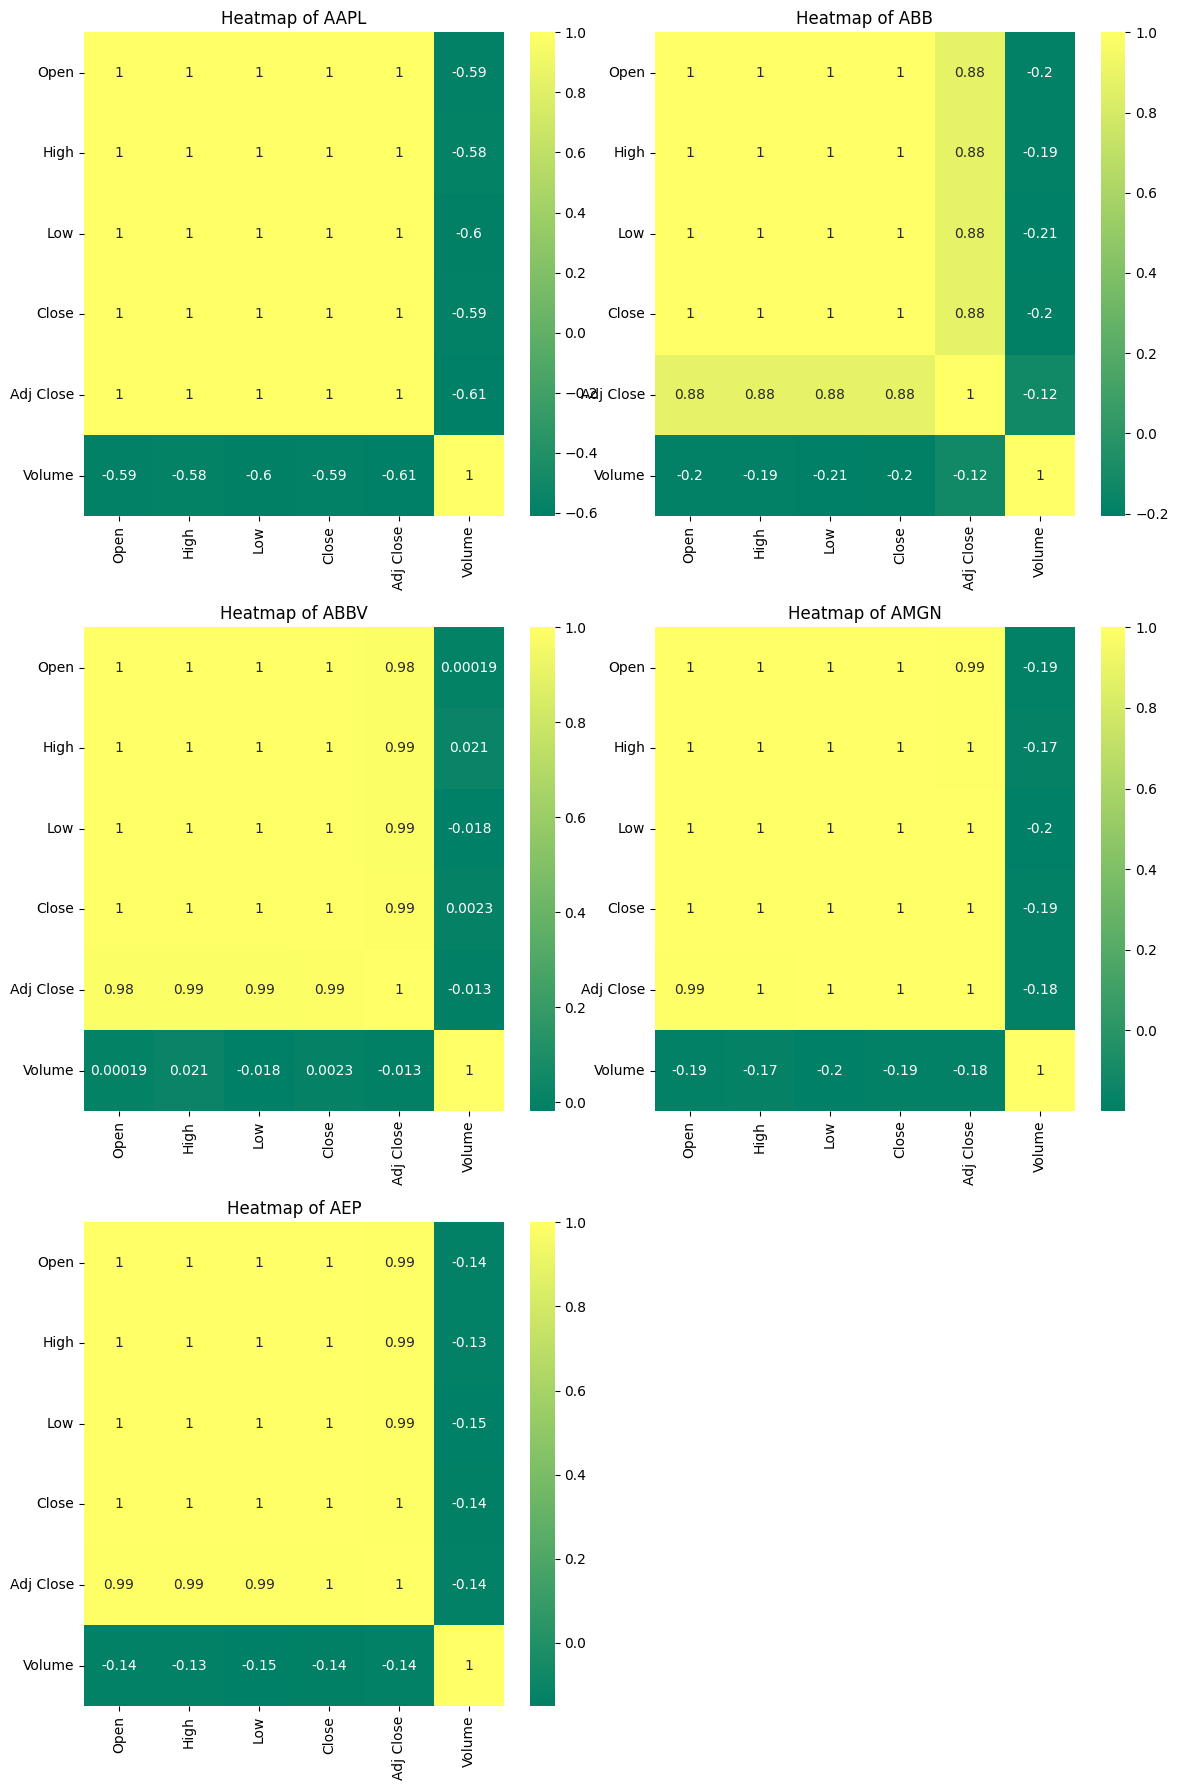

In [ ]:
plt.figure(figsize=(12, 18))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list_not_date, 1):
    plt.subplot(3, 2, i)

    # Tính toán ma trận tương quan
    correlation_matrix = company.corr()

    # Vẽ heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='summer', cbar=True,
                xticklabels=correlation_matrix.columns,
                yticklabels=correlation_matrix.columns)

    plt.title(f"Heatmap of {tech_list[i - 1]}")

plt.tight_layout()
plt.show()

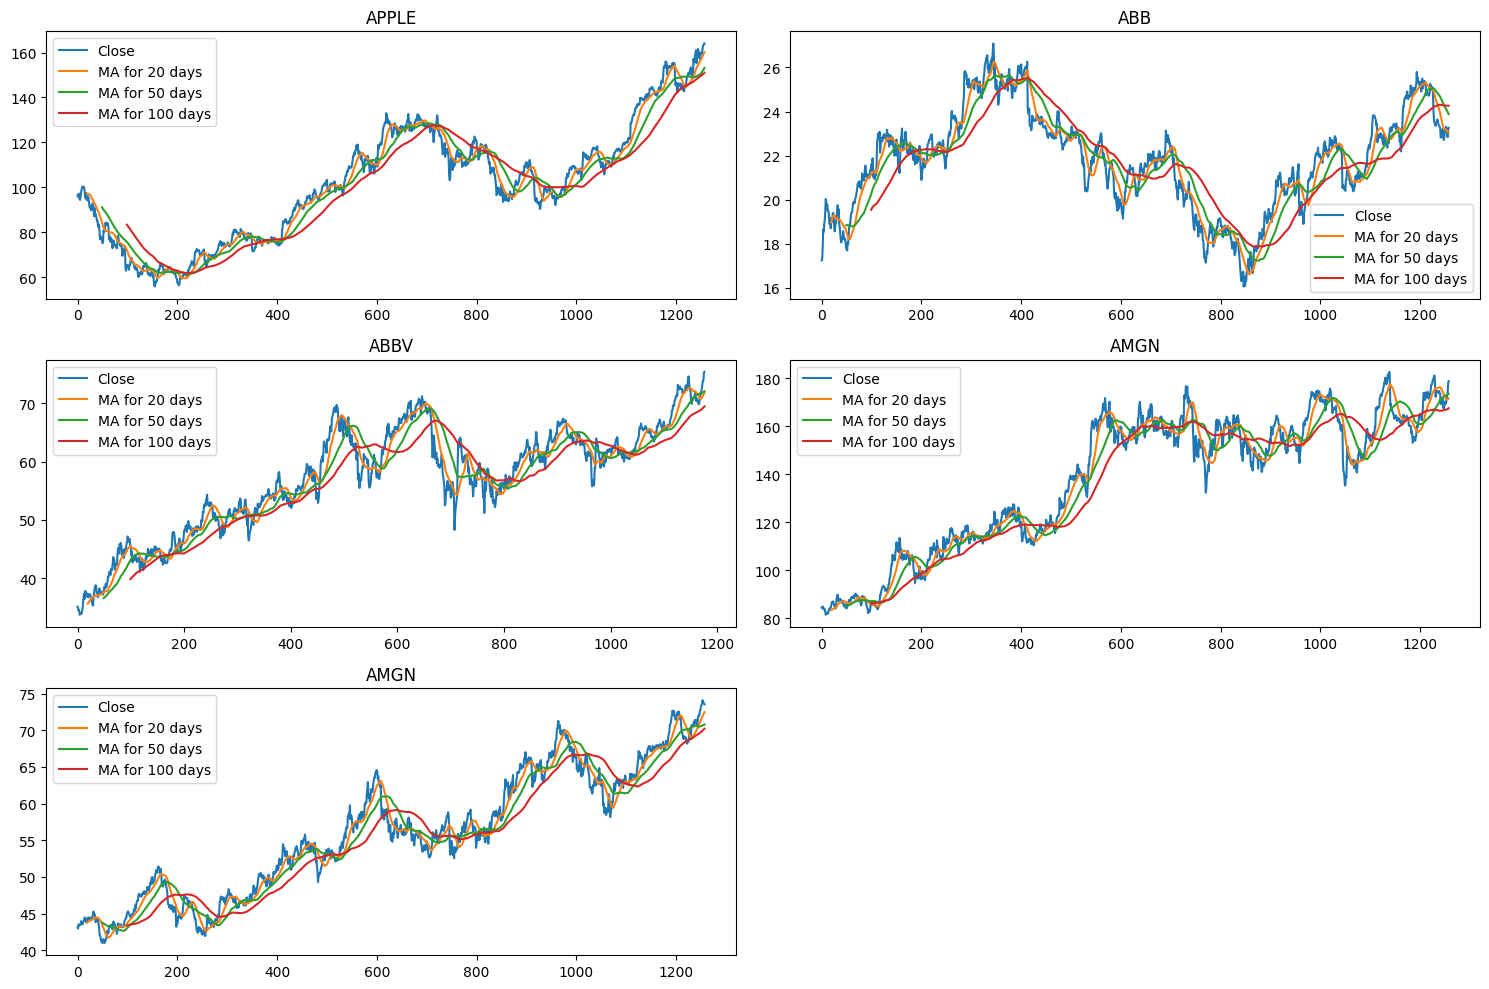

In [ ]:
ma_day = [20, 50, 100]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

ABB[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[0,1])
axes[0,1].set_title('ABB')

ABBV[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,0])
axes[1,0].set_title('ABBV')

AMGN[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMGN')

AEP[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[2,0])
axes[2,0].set_title('AMGN')
fig.delaxes(axes[2,1])
fig.tight_layout()

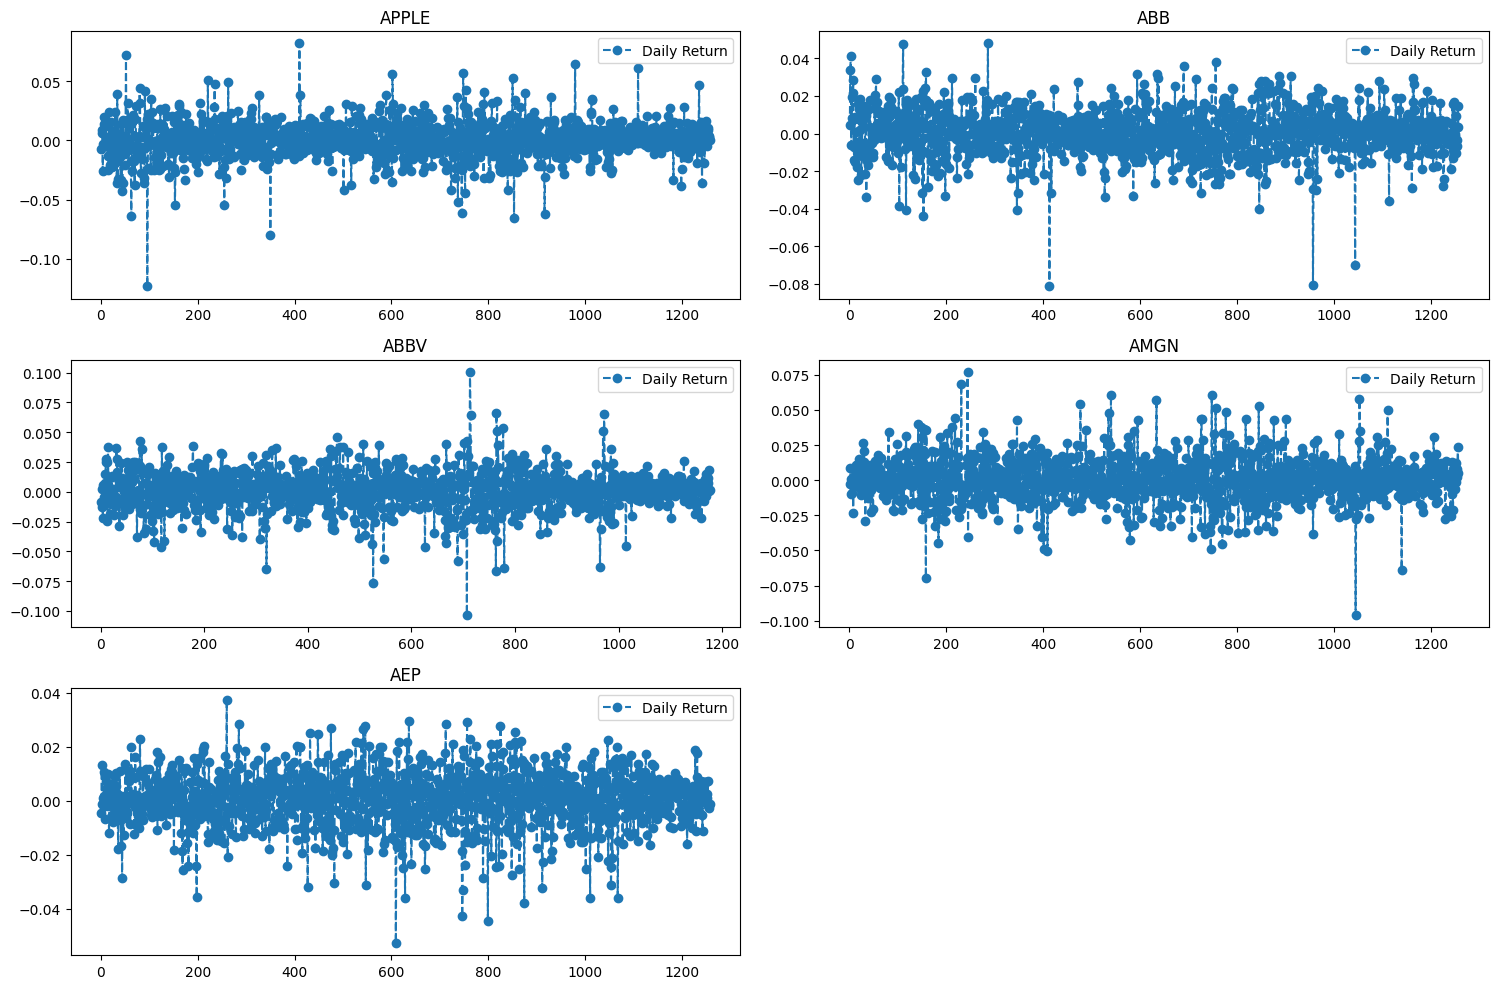

In [ ]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

ABB['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('ABB')

ABBV['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('ABBV')

AMGN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMGN')

AEP['Daily Return'].plot(ax=axes[2,0], legend=True, linestyle='--', marker='o')
axes[2,0].set_title('AEP')

fig.delaxes(axes[2,1])
fig.tight_layout()

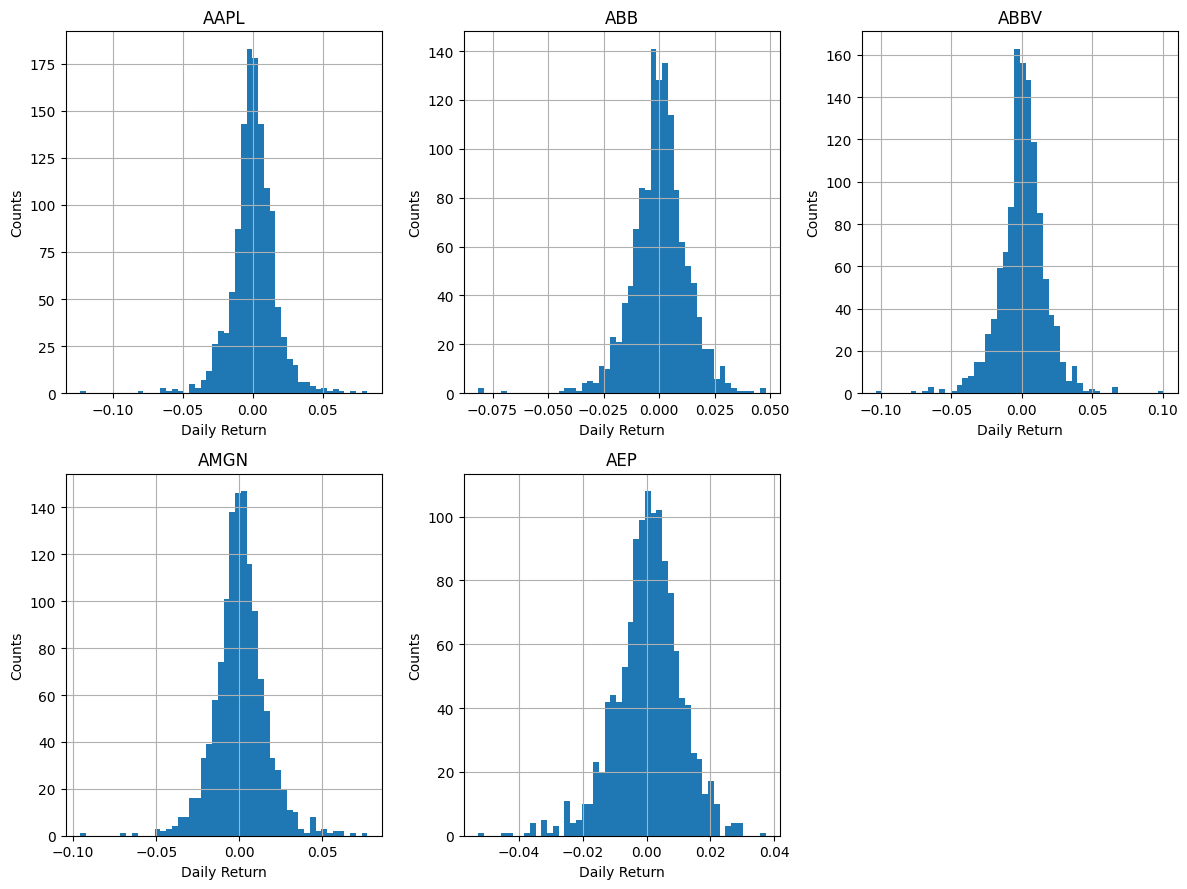

In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 3, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{tech_list[i - 1]}')

plt.tight_layout()

In [ ]:
closing_prices = pd.DataFrame({
    'AAPL': AAPL['Close'],
    'ABB': ABB['Close'],
    'ABBV': ABBV['Close'],
    'AMGN': AMGN['Close'],
    'AEP': AEP['Close']
})


print(closing_prices.head())

tech_rets = closing_prices.pct_change()

print(tech_rets.head())

        AAPL        ABB       ABBV       AMGN        AEP
0  96.424286  17.240000  35.119999  84.330002  43.139999
1  95.747147  17.320000  34.830002  84.080002  42.950001
2  96.610001  17.910000  34.389999  84.809998  43.520000
3  97.205711  18.650000  34.459999  83.959999  43.459999
4  94.677139  18.540001  33.709999  84.050003  43.389999
       AAPL       ABB      ABBV      AMGN       AEP
0       NaN       NaN       NaN       NaN       NaN
1 -0.007022  0.004640 -0.008257 -0.002965 -0.004404
2  0.009012  0.034065 -0.012633  0.008682  0.013271
3  0.006166  0.041318  0.002035 -0.010022 -0.001379
4 -0.026013 -0.005898 -0.021764  0.001072 -0.001611


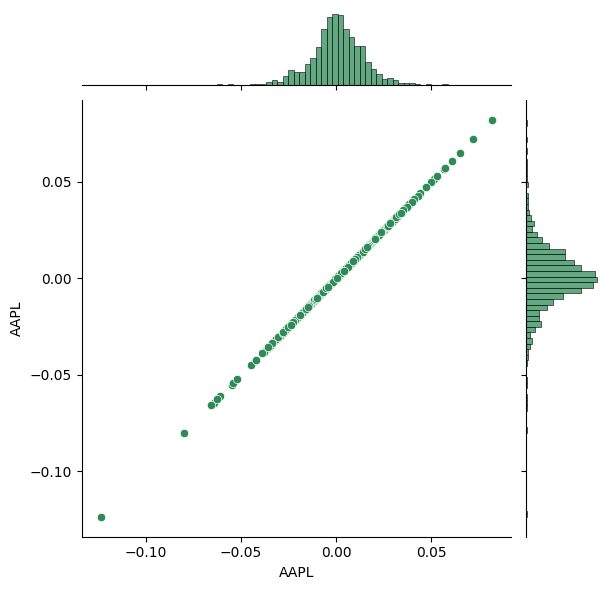

In [ ]:
# Comparing AAPL to itself should show a perfectly linear relationship
sns.jointplot(x='AAPL', y='AAPL', data=tech_rets, kind='scatter', color='seagreen')

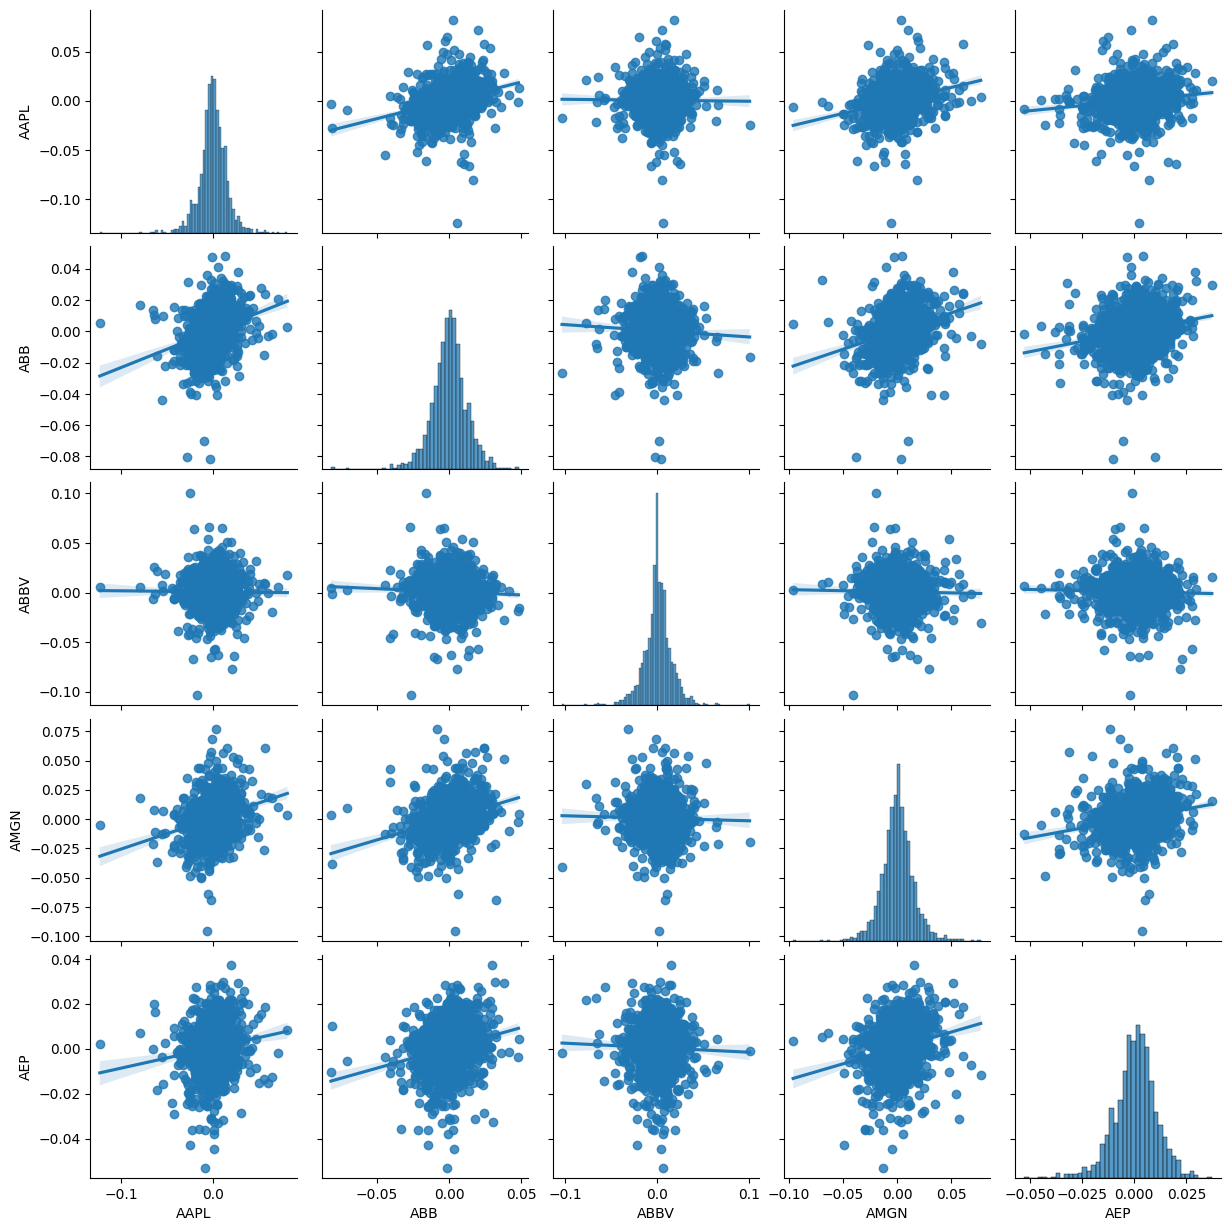

In [ ]:
sns.pairplot(tech_rets, kind='reg')

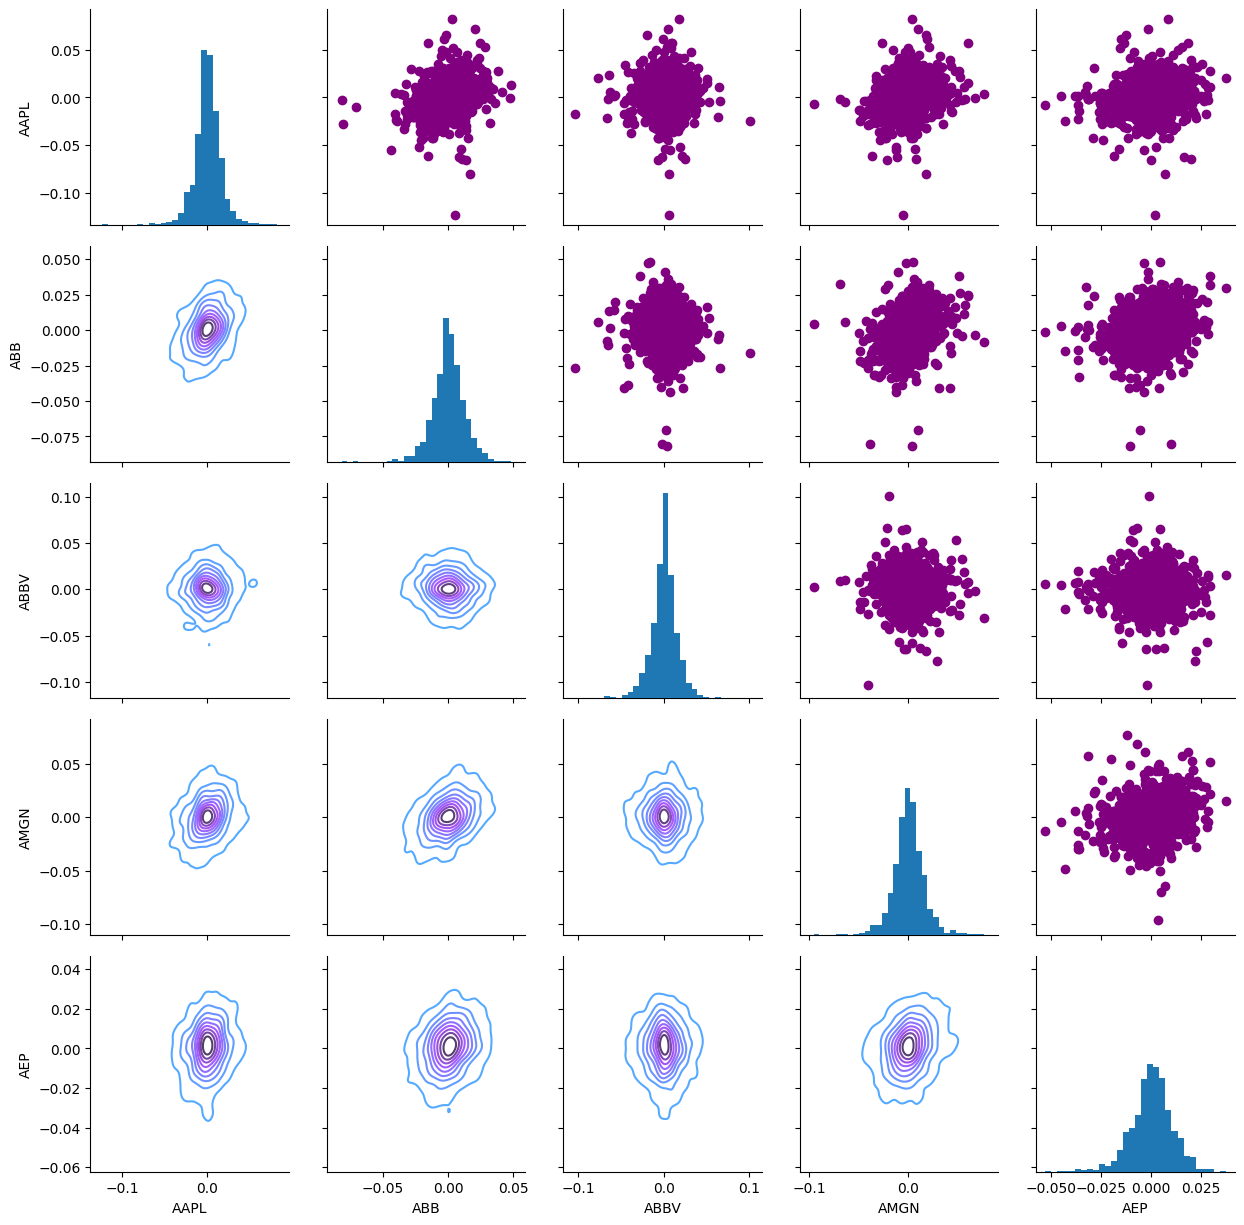

In [ ]:
return_fig = sns.PairGrid(tech_rets.dropna())

return_fig.map_upper(plt.scatter, color='purple')


return_fig.map_lower(sns.kdeplot, cmap='cool_d')

return_fig.map_diag(plt.hist, bins=30)


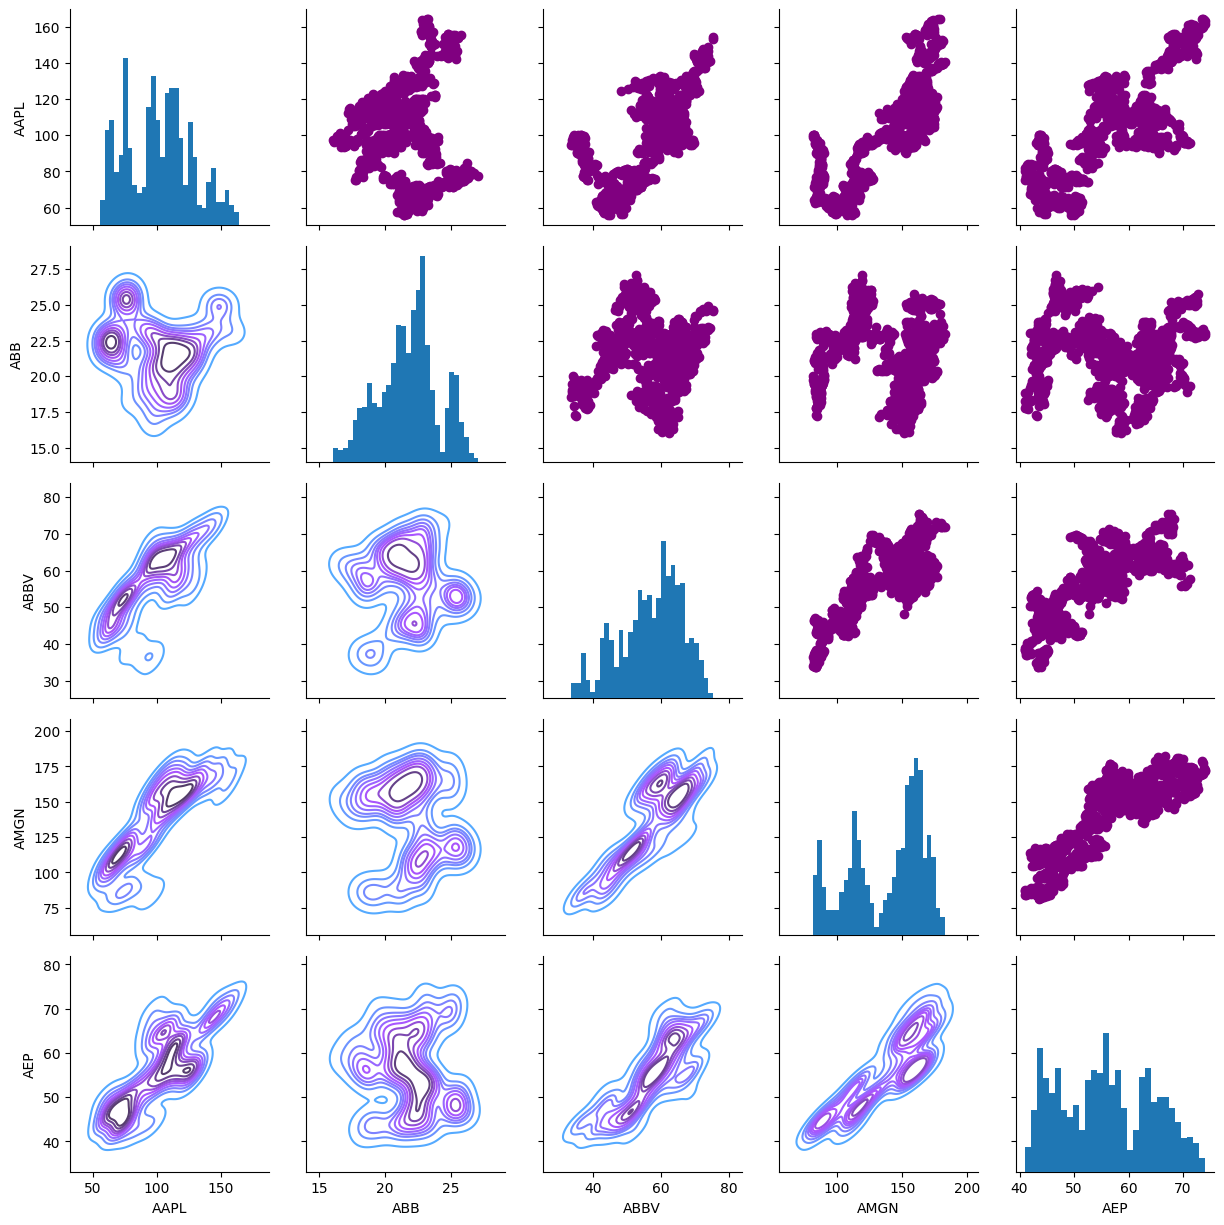

In [ ]:
# Thiết lập hình vẽ của chúng ta bằng cách đặt tên nó là returns_fig, gọi PairPlot trên DataFrame
returns_fig = sns.PairGrid(closing_prices)

# Sử dụng map_upper để chỉ định hình dạng của tam giác trên.
returns_fig.map_upper(plt.scatter, color='purple')

# Chúng ta cũng có thể xác định tam giác dưới trong hình vẽ, bao gồm kiểu biểu đồ (kde) hoặc bảng màu (cool_d)
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Cuối cùng, chúng ta sẽ định nghĩa đường chéo là một loạt các biểu đồ histogram của lợi nhuận hàng ngày
returns_fig.map_diag(plt.hist, bins=30)


Text(0.5, 1.0, 'Correlation of stock closing price')

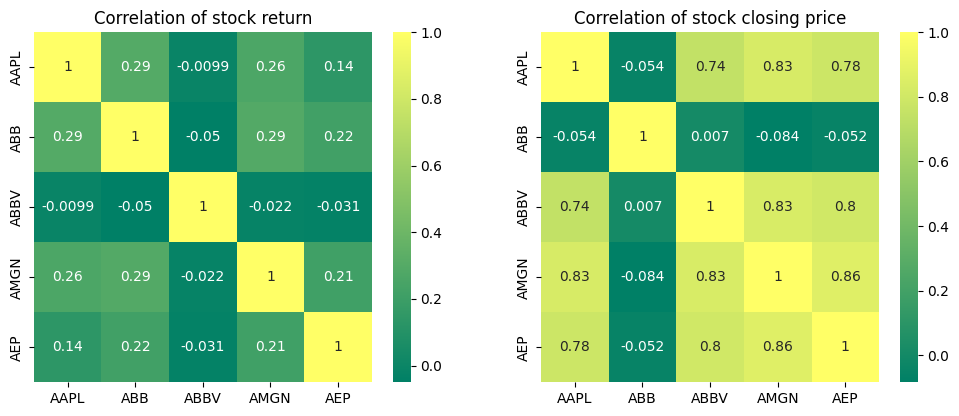

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_prices.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

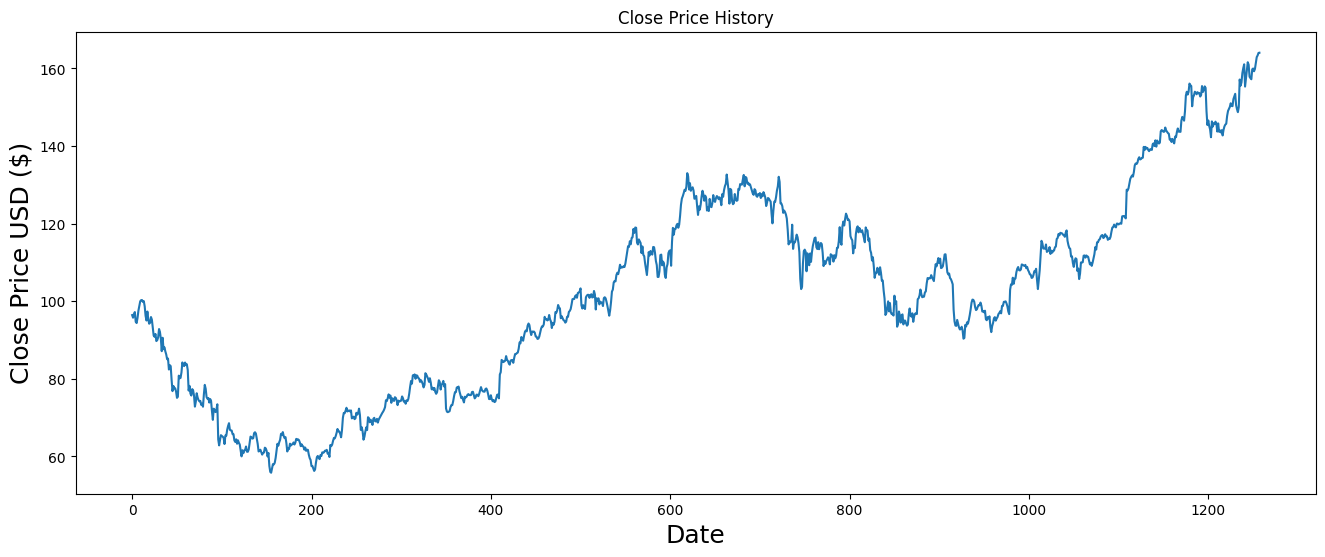

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(AAPL['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()